In [2]:
import numpy as np
import jax
from jax import jit, vmap, grad, random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from scipy.optimize import fsolve, root, bisect

%config InlineBackend.figure_format = 'retina'

sns.set_style('whitegrid')
!nvidia-smi

Thu Apr  4 14:16:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:CA:00.0 Off |                    0 |
| N/A   26C    P0              51W / 400W |      4MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
def df_1(etas, lamb):
  return jnp.mean(etas/(lamb+etas))

def df_2(etas, lamb):
  return jnp.mean((etas/(lamb+etas))**2)

def tf_1(etas, ws, lamb):
  return jnp.sum((ws**2) * etas/(lamb+etas))

def tf_1p(etas, ws, lamb):
  return jnp.sum((ws**2)*etas/(lamb+etas)**2)

def tf_2(etas, ws, lamb):
  return jnp.sum((ws**2) * etas**2/(lamb+etas)**2)

def newton(f, x0, max_step=100, abs_tol=1e-5, rel_tol=1e-10, eta=1.0):
    x = x0
    gf = grad(f)
    for _ in range(max_step):
        x_next = x - eta*f(x)/gf(x)
        if abs(f(x_next)) < abs_tol:
            return x_next
        x = x_next
    return None

def solve_kappa2(P, Ns:list, lamb, etaX, upper_bound=1e3, anneal_steps=0):
  D = Ns[0]
  if lamb == 0:
    if D == min(P, *Ns):
      return 0
    elif P == min(P, *Ns):
      fn = lambda kappa: 1 - D/P * df_1(etaX, kappa)
    else:
      N = min(Ns)
      fn = lambda kappa: N/D - df_1(etaX, kappa)
    return newton(fn, x0=upper_bound)
  def fn_lamb(kappa, lamb):
    ans = kappa * (1 - D/P * df_1(etaX, kappa))
    for N in Ns[1:]:
      ans *= N/D - df_1(etaX, kappa)
    return ans - lamb
  if anneal_steps:
    anneal_schedule = np.logspace(np.log10(lamb), 0, num=anneal_steps+1)[::-1]
    kappa = upper_bound
    for anneal_lamb in anneal_schedule:
      fn = lambda kappa: fn_lamb(kappa, anneal_lamb)
      kappa_next = newton(fn, x0=kappa)
      if not kappa: 
        print("Annealing didn't find kappa. Returning last value.")
        return kappa
      kappa = kappa_next
    return kappa
  else:
    fn = lambda kappa: fn_lamb(kappa, lamb)
    return newton(fn, x0=upper_bound)
  

def estimate_S(q,lamb, X_tr, hat_op):
  P = X_tr.shape[0]
  if q >= 1:
    return (lamb*jnp.trace(jnp.linalg.inv(X_tr @ X_tr.T + P*lamb*np.identity(P))))**(-1)
  else:
    return 1/(1-jnp.trace(hat_op @ X_tr) / P)  


In [4]:
def simulate_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_specs, teacher, X_te, y_te, num_X_seeds, num_F_seeds):
    if type(lambs) != list:
        lambs = [lambs]*len(qs)
    data = {}
    L = len(Ns)
    D = Ns[0]
    N = Ns[-1]
    Ss = [jnp.diag(X_spec)]
    for F_spec in F_specs:
        Ss.append(jnp.diag(F_spec))        
    w = teacher
    for i in tqdm(range(len(qs))):
        q, lamb  = qs[i], lambs[i]
        P = int(D/q)
        y_hats = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        y_hats_clean = np.zeros((num_X_seeds, num_F_seeds, X_te.shape[0]))
        df1_empirical = np.zeros((num_X_seeds, num_F_seeds))
        kappa_GCV = np.zeros((num_X_seeds, num_F_seeds))
        Etrs = np.zeros((num_X_seeds, num_F_seeds))
        for X_seed in range(num_X_seeds):
            X_key = random.PRNGKey(X_seed)
            X_tr_key, e_key= random.split(X_key)

            epsilon = random.normal(e_key, (P, )) * sigma_epsilon
            X_tr = random.normal(X_tr_key, (P, D)) @ jnp.sqrt(Ss[0])
        
            y_tr = X_tr @ w + epsilon
            y_tr_clean = X_tr @ w

            for F_seed in range(num_F_seeds):
                F_key = random.PRNGKey(F_seed)
                F_keys = random.split(F_key, L)
                F = jnp.identity(D)
                for l in range(1, L):
                    F_l = random.normal(F_keys[l], (Ns[l-1], Ns[l])) @ jnp.sqrt(Ss[l])/np.sqrt(D)
                    F = F @ F_l
                FX_tr = X_tr @ F
                FX_te = X_te @ F
                if 0.8 * D < P < 1.2 * D:
                    cov = FX_tr.T @ FX_tr
                    hat_op = jnp.linalg.pinv(cov + P*lamb*np.identity(N)) @ FX_tr.T
                    y_hat_te = FX_te @ hat_op @ y_tr
                    y_hat_te_clean = FX_te @ hat_op @ y_tr_clean
                elif P > D:
                    cov = FX_tr.T @ FX_tr
                    hat_op = jnp.linalg.inv(cov + P*lamb*np.identity(N)) @ FX_tr.T
                else: 
                    gram = FX_tr @ FX_tr.T
                    hat_op = FX_tr.T @ jnp.linalg.inv(gram + P*lamb*np.identity(P))
                    
                y_hat_te = FX_te @ hat_op @ y_tr
                y_hat_te_clean  = FX_te @ hat_op @ y_tr_clean
                y_hats[X_seed, F_seed, :] = y_hat_te
                y_hats_clean[X_seed, F_seed, :] = y_hat_te_clean

                if P > D:
                    cov = FX_tr.T @ FX_tr
                    df_F = jnp.trace(cov @ jnp.linalg.inv(cov + P*lamb*np.identity(N)))
                    kappa_GCV[X_seed, F_seed] = lamb / (1 - 1/P * df_F) 
                    y_hat_tr = FX_tr @ hat_op @ y_tr
                    E_tr = jnp.mean((y_tr - y_hat_tr)**2).item()
                else:
                    gram = FX_tr @ FX_tr.T
                    g = jnp.linalg.inv(gram + P*lamb*np.identity(P))
                    kappa_GCV[X_seed, F_seed] = jnp.trace(g)**(-1)
                    E_tr = lamb**2/P * jnp.linalg.norm(P * g @ y_tr)**2
                Etrs[X_seed, F_seed] = E_tr

        Eg = np.mean((y_hats - y_te[None, None, :])**2, axis=-1)
        Signal = np.mean((y_hats_clean - y_te[None, None, :])**2, axis=-1)
        Noise = np.mean((y_hats - y_hats_clean)**2, axis=-1)
        Bias =  np.mean((y_te - np.mean(y_hats_clean, axis=(0, 1)))**2)
        VarX = np.mean((jnp.mean(y_hats_clean, axis=1) - y_te[None, :])**2, axis=-1) - Bias
        VarF = np.mean((jnp.mean(y_hats_clean, axis=0) - y_te[None, :])**2, axis=-1) - Bias
        VarXF =  Signal - VarX - VarF - Bias
        VarXe = jnp.mean((jnp.mean(y_hats - y_hats_clean, axis=1))**2, axis=-1)
        VarXFe = Noise - VarXe
        data[q] = {
            'Eg': np.mean(Eg),
            'Eg_std': np.std(Eg),
            'Signal': np.mean(Signal),
            'Signal_std': np.std(Signal),
            'Noise': np.mean(Noise),
            'Noise_std': np.std(Noise),
            'Bias': Bias,
            'VarX': np.mean(VarX),
            'VarX_std': np.std(VarX),
            'VarF': np.mean(VarF),
            'VarF_std': np.std(VarF),
            'VarXF': np.mean(VarXF),
            'VarXF_std': np.std(VarXF),
            'VarXe': np.mean(VarXe),
            'VarXe_std': np.std(VarXe),
            'VarXFe': np.mean(VarXFe),
            'VarXFe_std': np.std(VarXFe),
            'Etr': np.mean(Etrs),
            'Etr_std': np.std(Etrs),
            'df1': np.mean(df1_empirical),
            'df1_std': np.std(df1_empirical),
            'kappa_GCV': np.mean(kappa_GCV),
            'kappa_GCV_std': np.std(kappa_GCV)
        }
        data[q]

    dataT = {}
    for key in data[qs[0]]:
        dataT[key] = np.array([data[q][key] for q in data])
    return dataT
    

def solve_theory(Ns, qs, lambs, sigma_epsilon, X_spec, F_spec, teacher, anneal_steps=0):
    if type(lambs) != list:
        lambs = np.array([lambs]*len(qs))
    D = Ns[0]
    kappa2 = jnp.array([
        solve_kappa2(D/q, Ns, lamb=lamb, etaX=X_spec, anneal_steps=anneal_steps)
          for lamb, q in zip(lambs, qs)])
    df1k2 = jnp.array([df_1(X_spec, k) for k in kappa2])
    df2k2 = jnp.array([df_2(X_spec, k) for k in kappa2])
    tf1pk2 = jnp.array([tf_1p(X_spec, teacher, k) for k in kappa2])
    tf1k2 = jnp.array([tf_1(X_spec, teacher, k) for k in kappa2])
    tf2k2 = jnp.array([tf_2(X_spec, teacher, k) for k in kappa2])
    gamma2 = qs * df2k2
    kappa1 = kappa2
    for N in Ns[1:]:
        kappa1 *= (N/D - df1k2)
    dlogS = 0
    for N in Ns[1:]:
        dlogS += df1k2/(N/D - df1k2)
    dlogk1k2 = 1 + (df1k2-df2k2)/df1k2 * dlogS
    dlogk2k1 = 1/dlogk1k2
    gamma1 = qs * df1k2 * (1 - (df1k2 - df2k2)/df1k2 * dlogk2k1)
    
    signal = (kappa2**2 * tf1pk2 * dlogk2k1 + kappa2*tf1k2 * ( 1 - dlogk2k1) ) /(1-gamma1)
    noise = sigma_epsilon**2 * gamma1/(1-gamma1)
    bias = kappa2**2 * tf1pk2
    varX = kappa2**2 * tf1pk2 * gamma2/(1-gamma2)
    varXe = sigma_epsilon**2 * gamma2/(1-gamma2)
    varXFe = noise - varXe
    varF = (1 - dlogk2k1) * kappa2 * tf2k2
    varXF = signal - varX - varF - bias
    Eg = signal + noise
    Etr = ((lambs/kappa1)**2)*(Eg + sigma_epsilon**2)
    data = {
        'kappa2': kappa2,
        'kappa1': kappa1,
        'df1k2': df1k2,
        'df2k2': df2k2,
        'tf1pk2': tf1pk2,
        'tf1k2': tf1k2,
        'tf2k2': tf2k2,
        'dlogS': dlogS,
        'dlogk2k1': dlogk2k1,
        'dlogk1k2': dlogk1k2,
        'gamma1': gamma1,
        'gamma2': gamma2,
        'Bias': bias,
        'VarX': varX,
        'VarF': varF,
        'VarXF': varXF,
        'VarXe': varXe,
        'VarXFe': varXFe,
        'Noise': noise,
        'Signal': signal,
        'Eg': Eg,
        'Etr': Etr
    }
    return data

## Unstructured Shallow

In [21]:
qs = np.logspace(-2, 2, 20)
P_te = 200
sigma_epsilon = 0.25

D = 200
N = 100
num_F_seeds = 40
num_X_seeds = 40

b1 = 0.0
b2 = 0.0
a = 0.0
lamb = 1e-3

etasX = jnp.arange(1, D+1)**(-b1)
etasF = jnp.arange(1, N+1)**(-b2)
SX = jnp.diag(etasX)
w = jnp.arange(1, D+1)**(-(a-b1)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, etasX, [etasF], w)


100%|██████████| 20/20 [02:15<00:00,  6.80s/it]


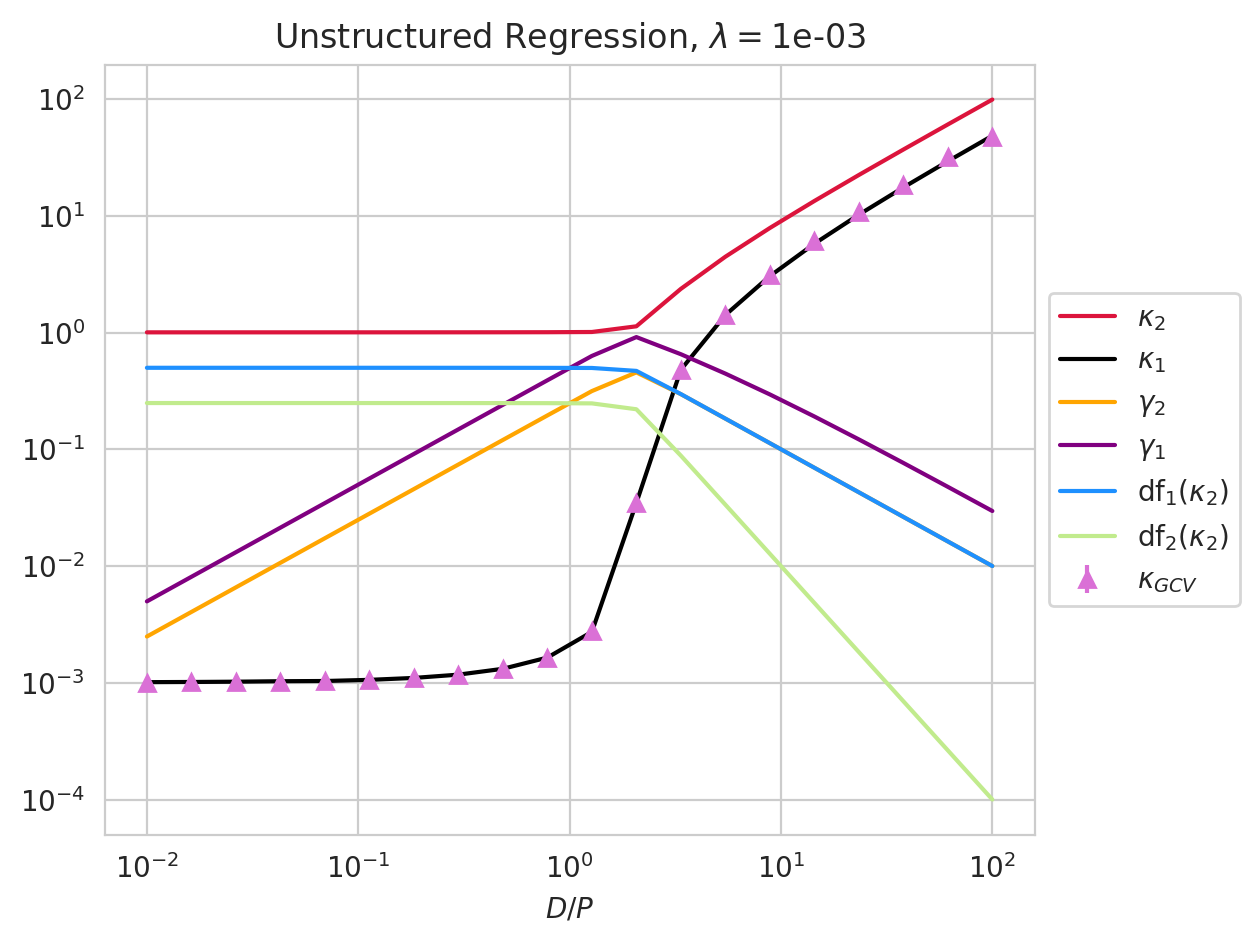

In [9]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(qs2, thry['df1k2'], label="df$_1(\\kappa_2)$", c='dodgerblue')
plt.plot(qs2, thry['df2k2'], label="df$_2(\\kappa_2)$", c='C4')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

# plt.plot(qs2, dlogk2k1, label="dlogk2k1", c='C1')
# plt.errorbar(qs2, [np.mean(df1_empirical[q]) for q in qs], [np.std(df1_empirical[q]) for q in qs] , marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}")
plt.savefig('figures/LRF_unstructured_params.pdf', bbox_inches='tight')

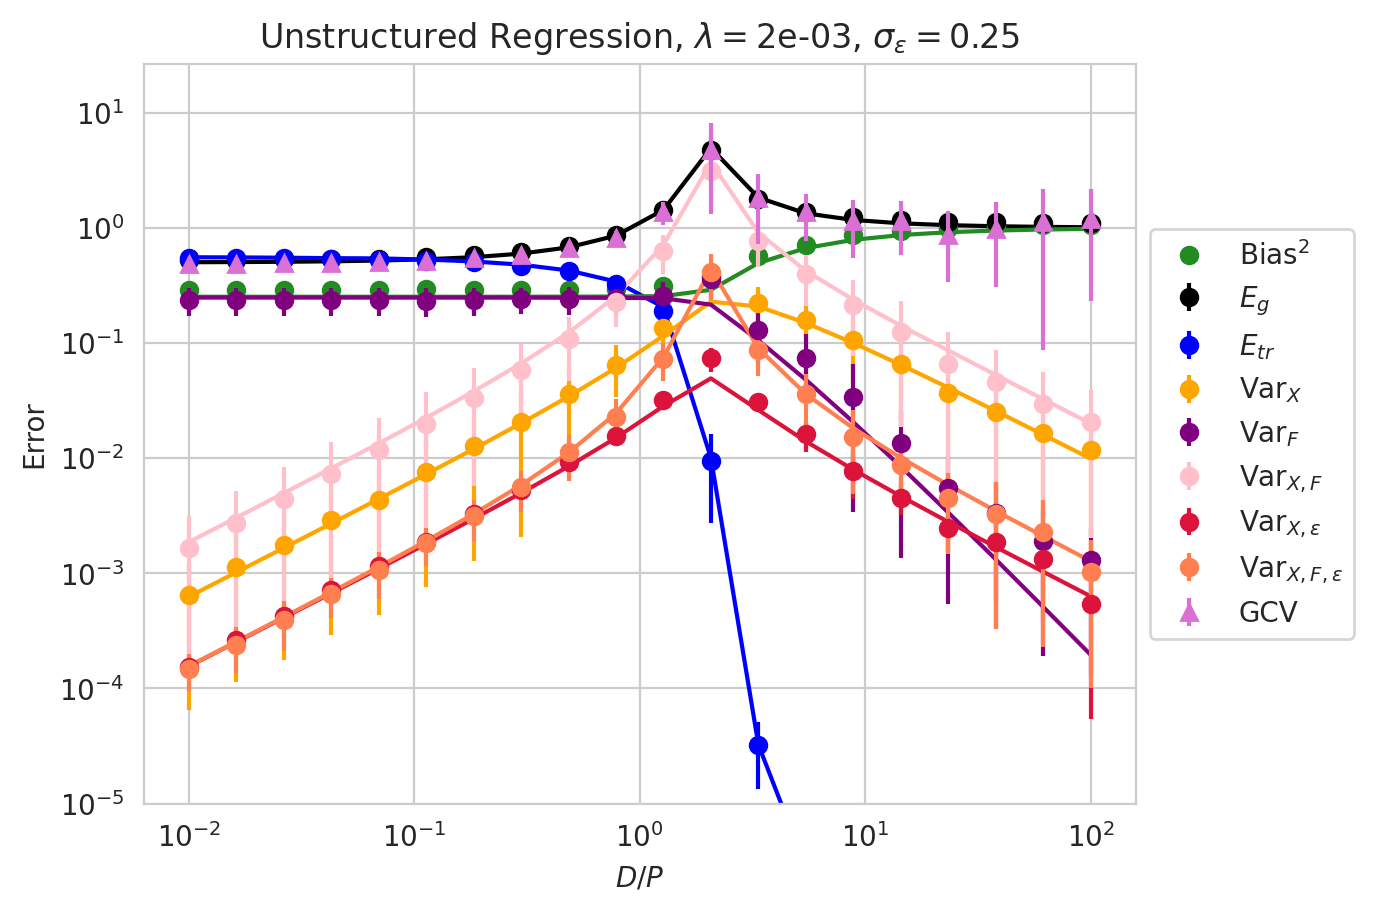

In [20]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'crimson', 'coral']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(qs, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.xlabel(r'$D/P$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(bottom=1e-5, top=None)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('figures/unstructured_LRF.pdf', bbox_inches='tight')

In [83]:
qs = np.logspace(0.5, 4, 20)
P_te = 200

D = 10_000
N = 1_000
F_seeds = list(range(10))
X_seeds = list(range(10))

b1 = 0.0
b2 = 0.0
a = 0.0
lamb = 2e-4
sigma_epsilon = 0.0

etasX = jnp.arange(1, D+1)**(-b1)
etasF = jnp.arange(1, N+1)**(-b2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-(a-b1)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, etasX, [etasF], w)


100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


Text(0.5, 1.0, 'Unstructured Regression, $\\lambda=$0.0002, $\\sigma_\\epsilon=$0.0')

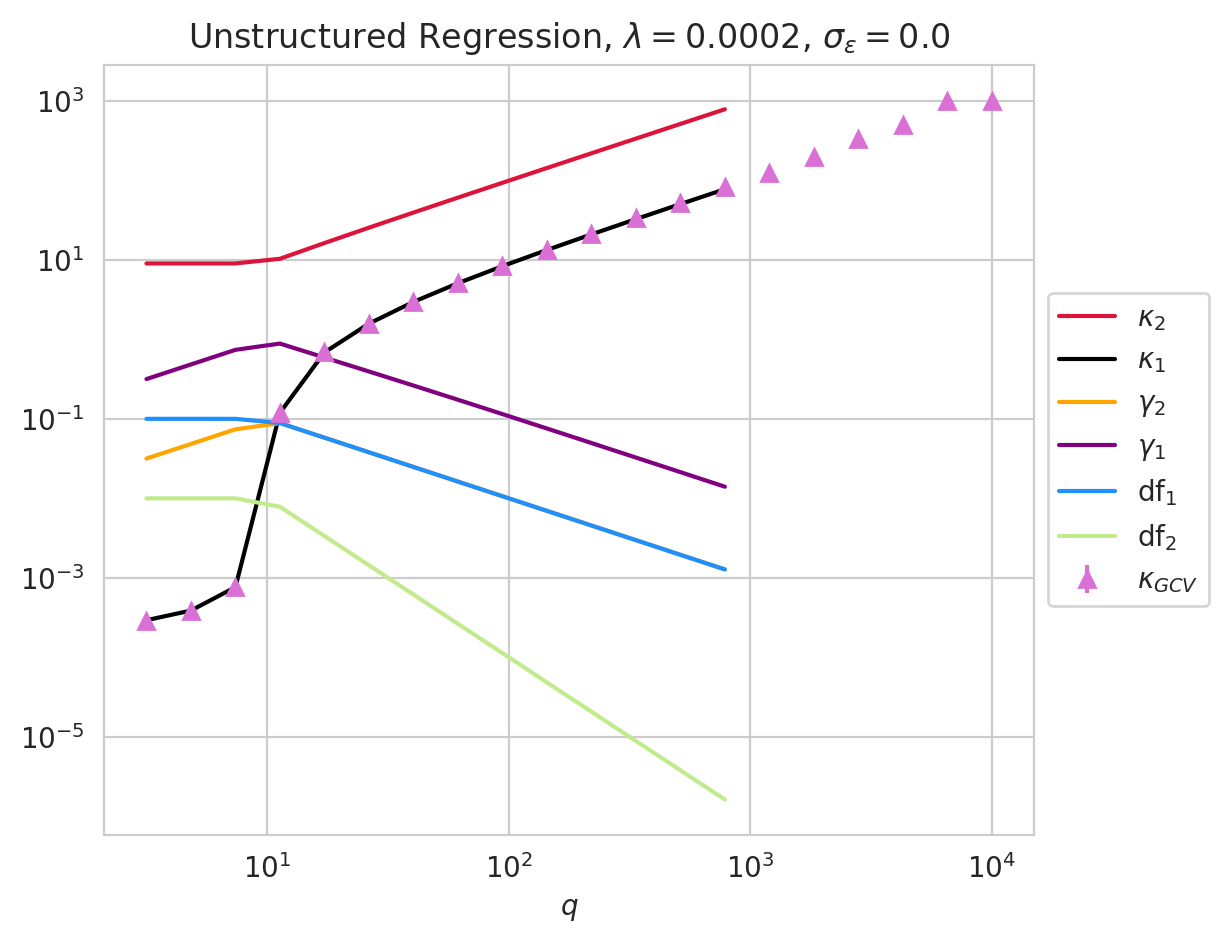

In [84]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(qs2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(qs2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

# plt.plot(qs2, dlogk2k1, label="dlogk2k1", c='C1')
# plt.errorbar(qs2, [np.mean(df1_empirical[q]) for q in qs], [np.std(df1_empirical[q]) for q in qs] , marker='o', linestyle="", label="df$_1$ emp", c='dodgerblue')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$q$')
plt.title(f"Unstructured Regression, $\\lambda=${lamb}, $\\sigma_\\epsilon=${sigma_epsilon}")

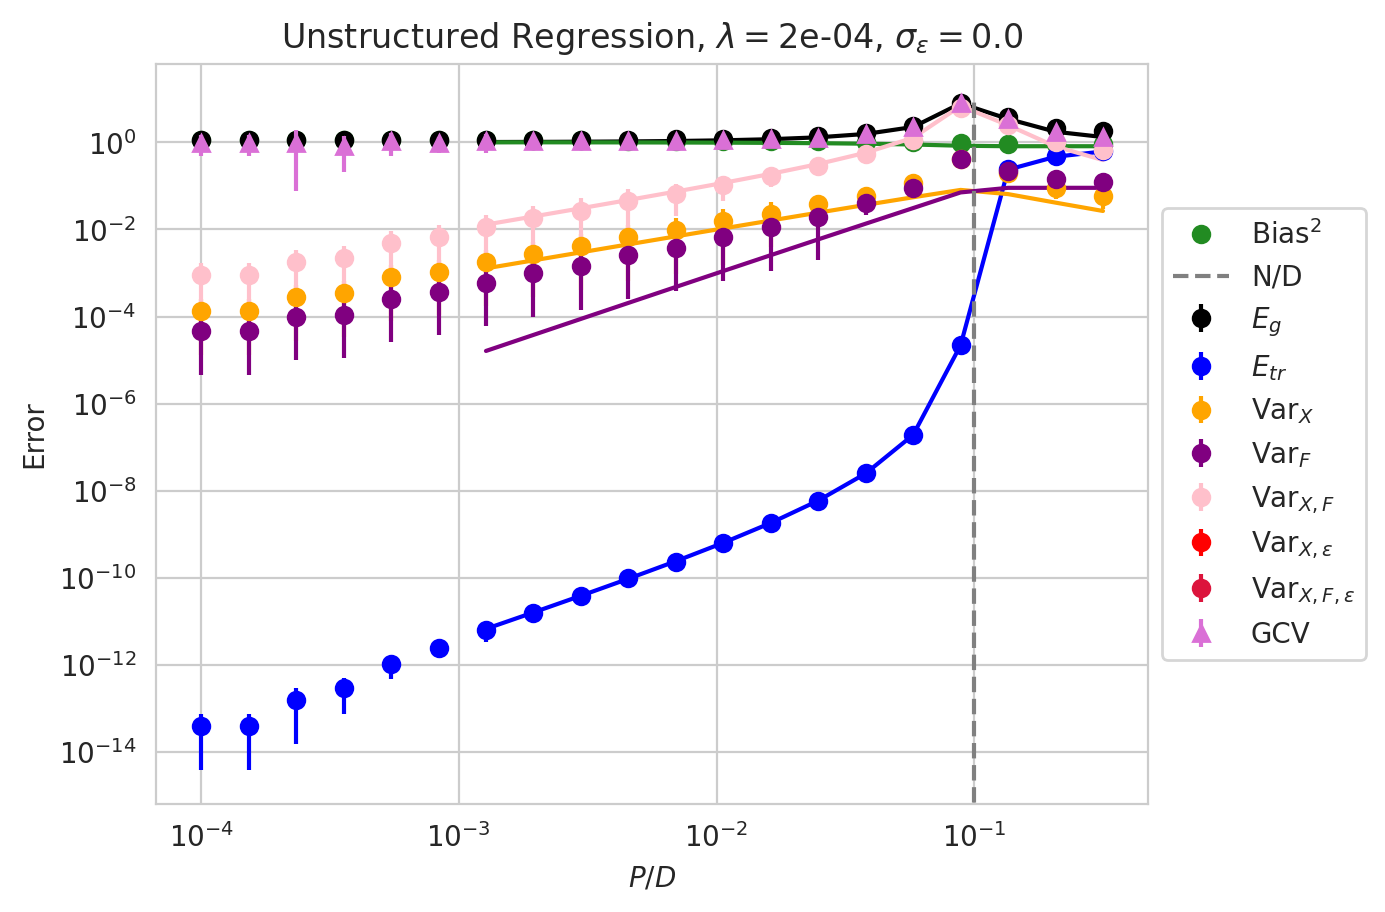

In [75]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'red', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(1/qs, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.plot([N/D, N/D], [0, 1e1], linestyle='--', color='grey', label="N/D")

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(1e-7, 1e1)
plt.title(f"Unstructured Regression, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Structured Shallow

In [20]:
qs = np.logspace(1, 2, 5)
P_te = 200

D = 10_000
N = 8000
num_F_seeds = 3
num_X_seeds = 3

b1 = 2.0
b2 = 0.0
a = 4.5
lamb = 0
sigma_epsilon = 0.0

etasX = jnp.arange(1, D+1)**(-b1)
etasF = jnp.arange(1, N+1)**(-b2)
SX = jnp.diag(etasX)
SF = jnp.diag(etasF)
w = jnp.arange(1, D+1)**(-(a-b1)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory([D, N], qs, lamb, sigma_epsilon, etasX, [etasF], w, X_te, y_te, num_X_seeds, num_F_seeds)


100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


KeyboardInterrupt: 

In [21]:
lamb=1e-8
thry = solve_theory([D, N], qs2, lamb, sigma_epsilon, etasX, [etasF], w, anneal_steps=3)

Text(0.5, 1.0, 'Structured Regression, $D=10000, N=8000$\n$a=$4.5, $b_1=$2.0 $\\lambda=$1e-08')

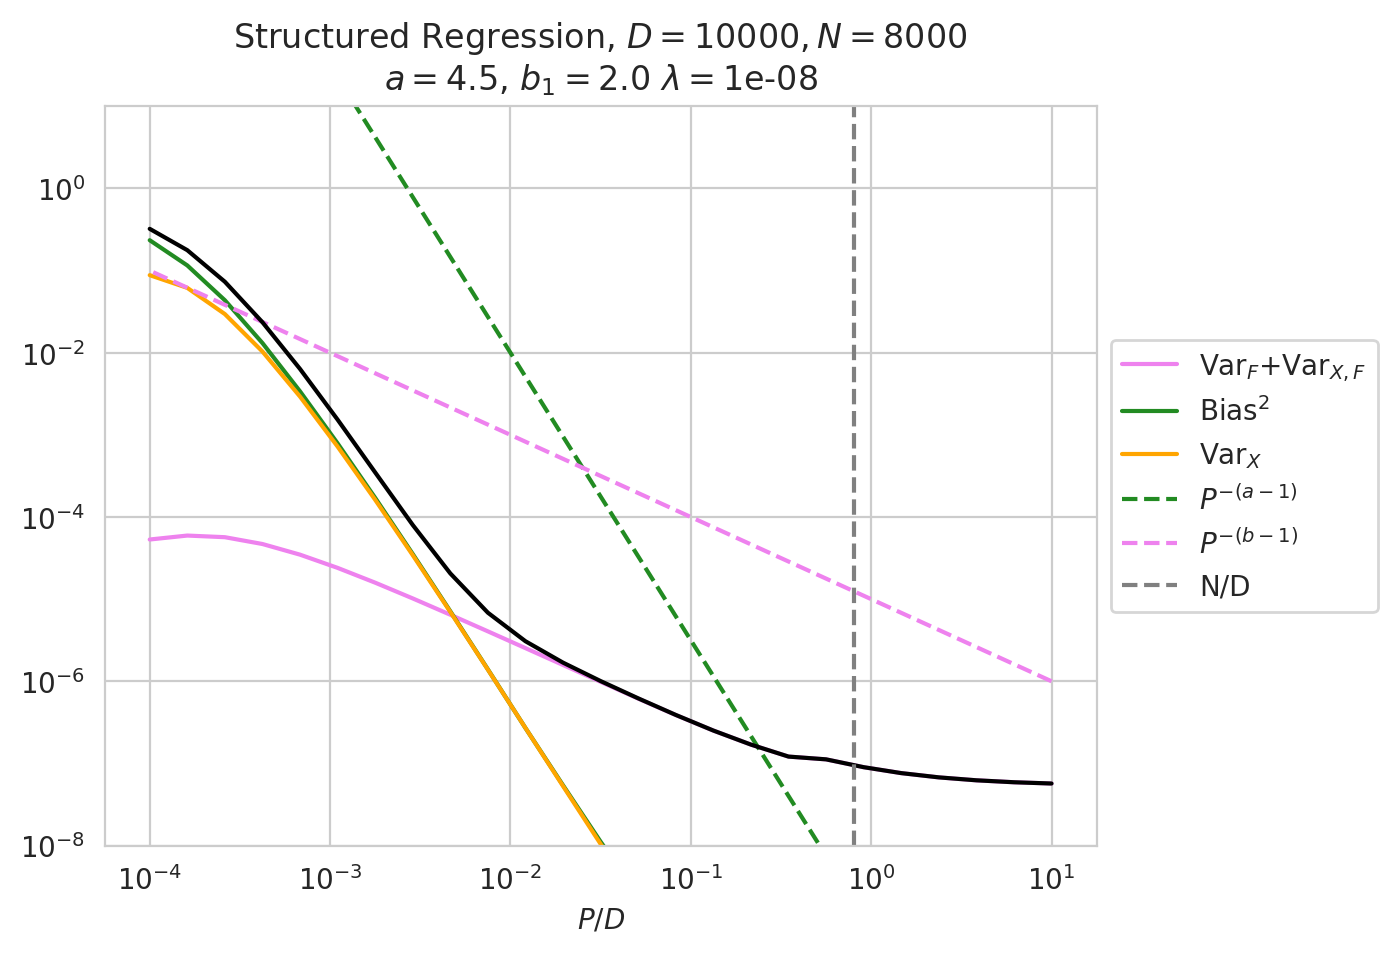

In [199]:
plt.loglog(1/qs2, thry['VarF']+thry['VarXF'], c='violet', label="Var$_F$+Var$_{{X, F}}$")
plt.loglog(1/qs2, thry['Bias'], c='forestgreen', label="Bias$^2$")
plt.loglog(1/qs2, thry['VarX'], c='orange', label="Var$_X$")
#plt.loglog(1/qs2, , c='orange', label="$\\gamma_1$")
plt.plot(1/qs2, 1e-9*qs2**(min(2*b1, a-1)), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
# plt.loglog(1/qs2, thry['gamma2'], c='crimson', label="$\\gamma_2$")
# plt.loglog(1/qs2, (1-thry['dlogk2k1'])/(1-thry['gamma1']), c='violet', label="$1-\\frac{{d \\log \\kappa_2}}{{d \\log \\kappa_1}}$")
# plt.loglog(1/qs2, thry['dlogS'], c='k', label="$\\frac{{d \\log S}}{{d \\log df_1}}$")

# plt.plot(1/qs2, (1/qs2)*(N/D - 1/qs2), '--', c='pink')
plt.plot(1/qs2, 1e-5*qs2**(min(b1-1, a-2)), '--', c='violet', label="$P^{{-(b-1)}}$")
# plt.plot(1/qs2, 1e-9*qs2**(a-1), '--', c='crimson', label="$P^{{-(a-1)}}$")
# plt.plot(1/qs2, 1e-5*qs2**(b1), '--', c='purple', label="$P^{{-b}}$")
# plt.plot(1/qs2, 1e-5*qs2**(2*b1), '--', c='blue', label="$P^{{-2b}}$")
plt.loglog(1/qs2, thry['Eg'], c='k')

plt.plot([N/D, N/D], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
plt.ylim(1e-8, 1e1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'$P/D$')
plt.title(f"Structured Regression, $D={D}, N={N}$\n$a=${a}, $b_1=${b1} $\\lambda=${lamb:.0e}")


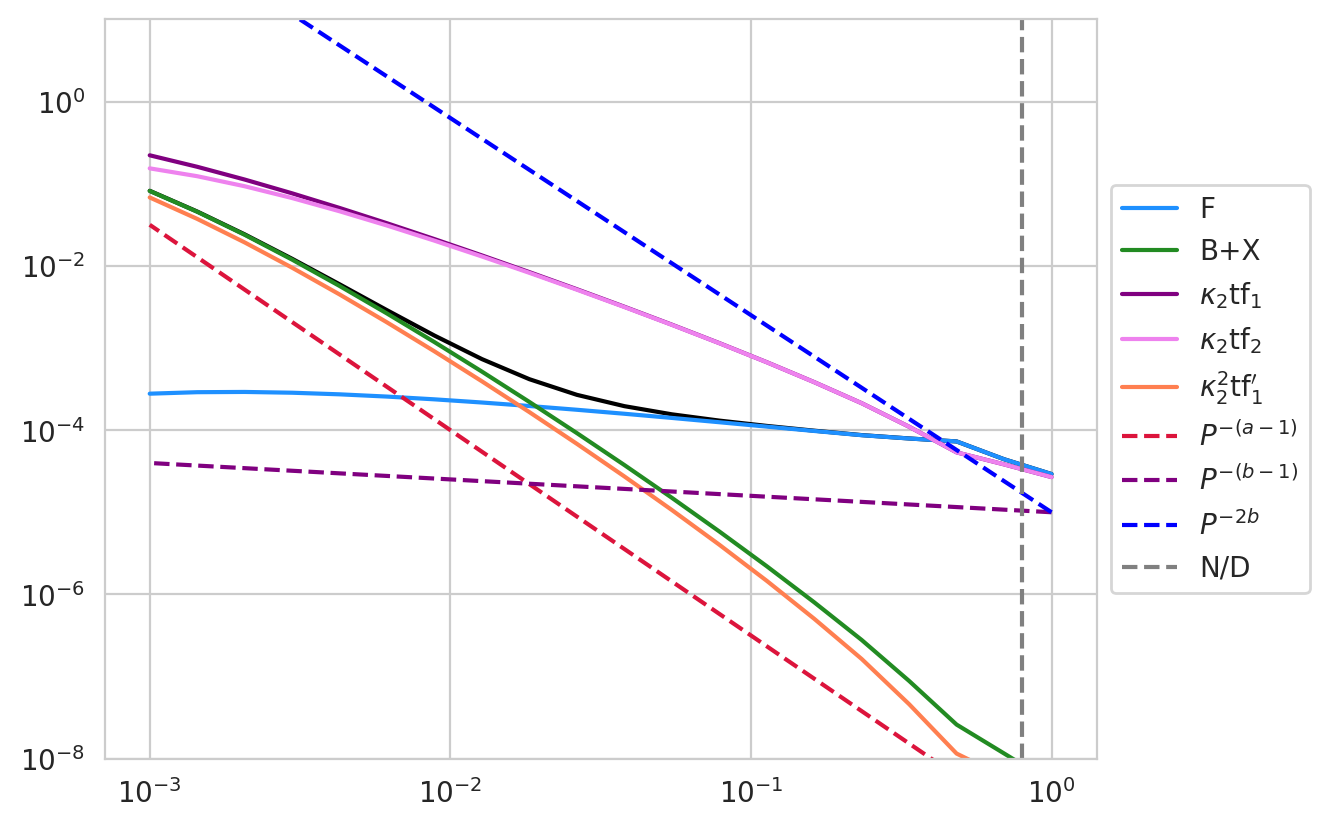

In [117]:
plt.loglog(1/qs2, thry['Eg'], c='k')
plt.loglog(1/qs2, thry['VarF']+thry['VarXF'], c='dodgerblue', label="F")
plt.loglog(1/qs2, thry['Bias']+thry['VarX'], c='forestgreen', label="B+X")
plt.loglog(1/qs2, thry['kappa2']*thry['tf1k2'], '-', c='purple', label="$\\kappa_2$tf$_1$")
plt.loglog(1/qs2, thry['kappa2']*thry['tf2k2'], '-', c='violet', label="$\\kappa_2$tf$_2$")
plt.loglog(1/qs2, thry['kappa2']**2*thry['tf1pk2'], '-', c='coral', label="$\\kappa_2^2$tf$_1'$")
plt.plot(1/qs2, 1e-9*qs2**(a-1), '--', c='crimson', label="$P^{{-(a-1)}}$")
plt.plot(1/qs2, 1e-5*qs2**(b1-1), '--', c='purple', label="$P^{{-(b-1)}}$")
plt.plot(1/qs2, 1e-5*qs2**(2*b1), '--', c='blue', label="$P^{{-2b}}$")
plt.plot([N/D, N/D], [1e-8, 1e1], linestyle='--', color='grey', label="N/D")
plt.ylim(1e-8, 1e1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

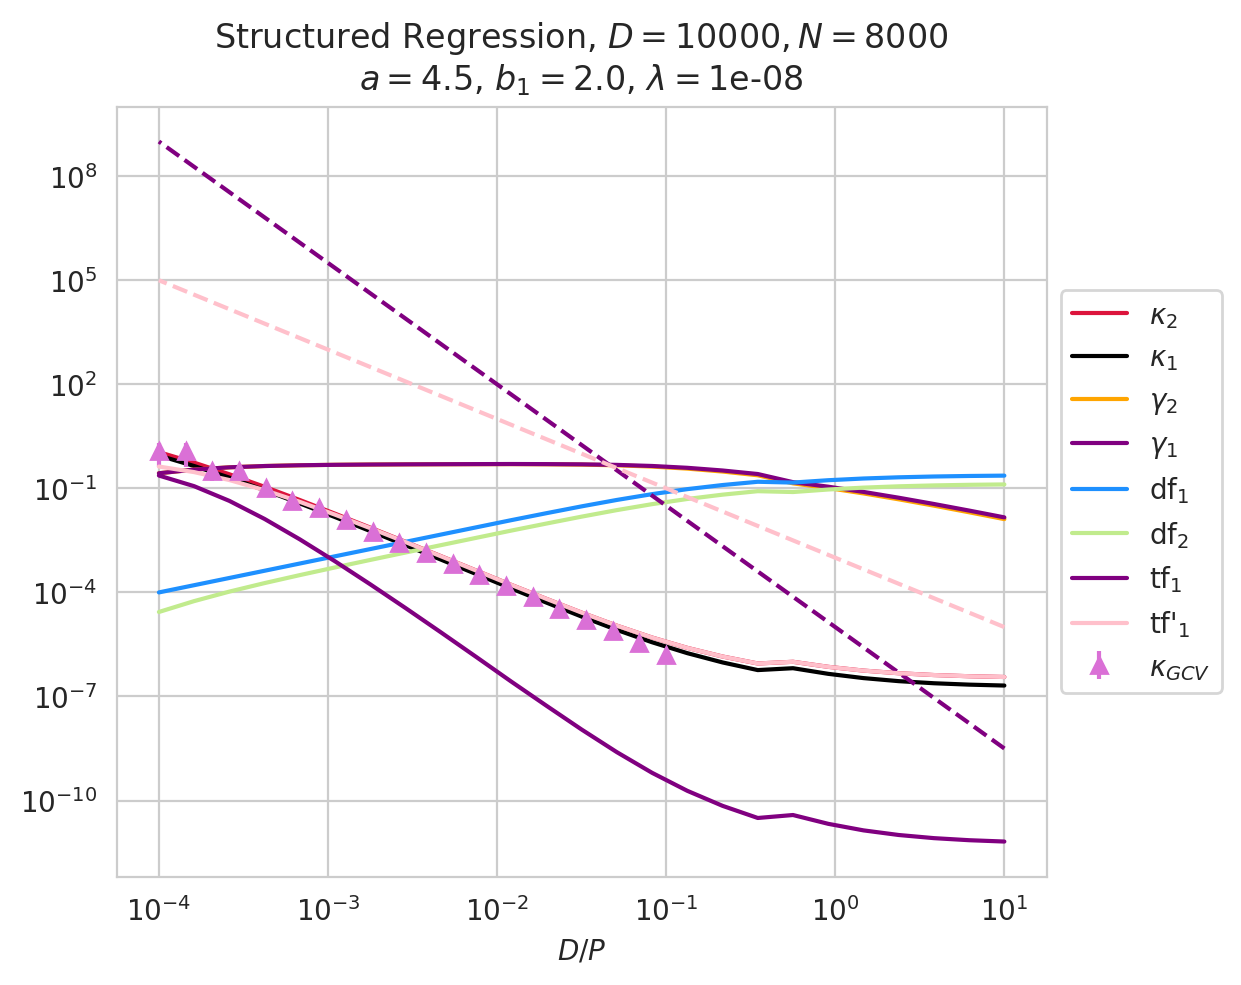

In [186]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(1/qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(1/qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(1/qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(1/qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(1/qs2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(1/qs2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(1/qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.plot(1/qs2,  (thry['kappa2']**2)*thry['tf1pk2'], label="tf$_1$", c='purple')
plt.plot(1/qs2, 1e-5*qs2**(a-1), '--', c='purple')
plt.plot(1/qs2, thry['kappa2']*thry['tf1k2'], label="tf$'_1$", c='pink')
plt.plot(1/qs2, 1e-3*qs2**(b1), '--', c='pink')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Structured Regression, $D={D}, N={N}$\n$a=${a}, $b_1=${b1}, $\\lambda=${lamb:.0e}")
plt.savefig('figures/structured_LRF_params.pdf', bbox_inches='tight')

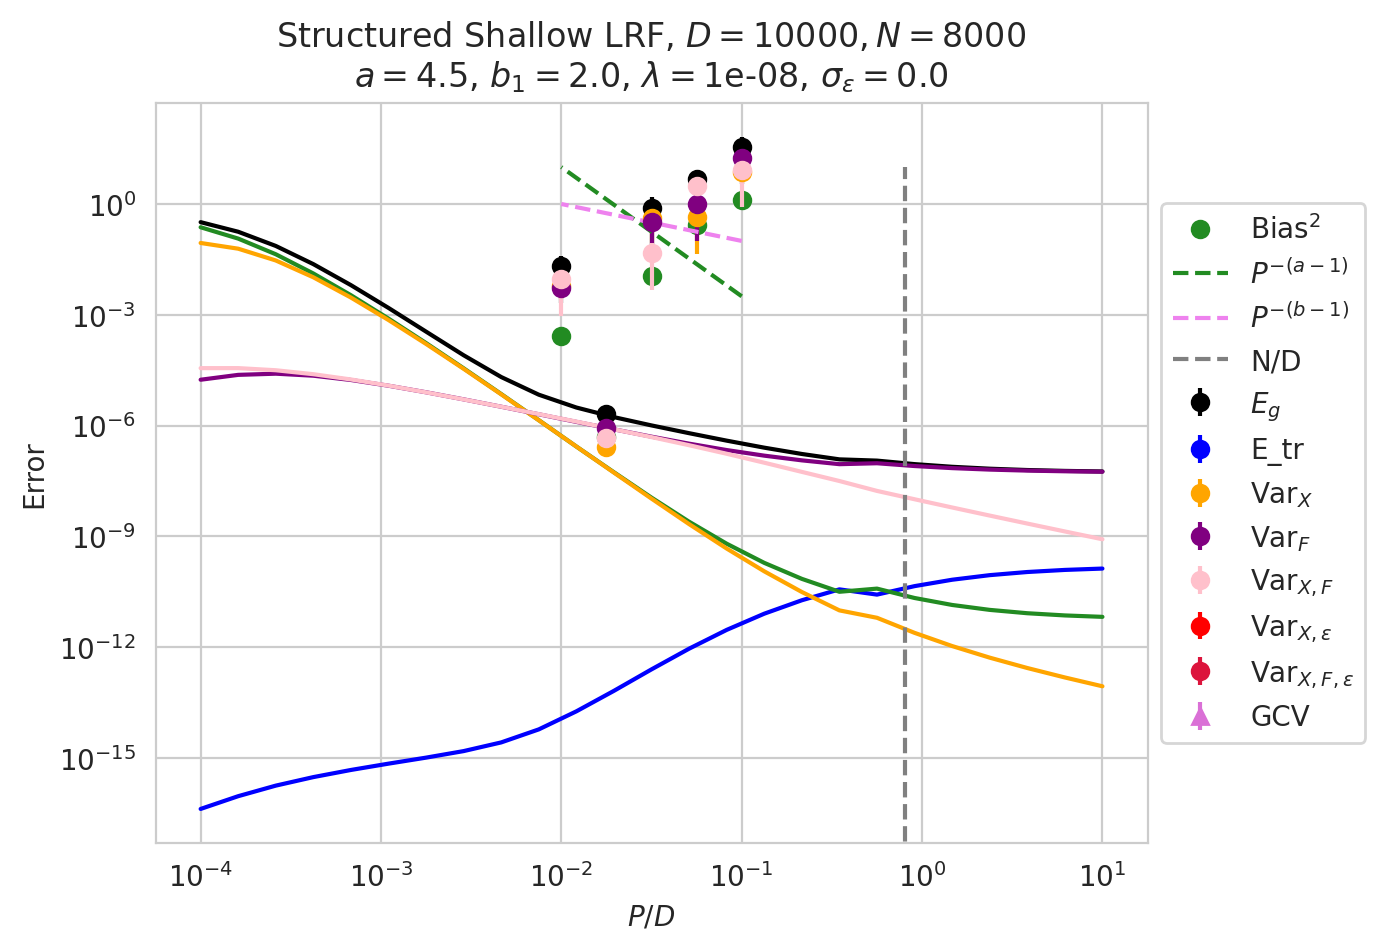

In [24]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k',  'b', 'forestgreen', 'orange', 'purple', 'pink', 'red', 'crimson']
labels = ["$E_g$", "E_tr", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(1/qs, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)


plt.plot(1/qs, 1e-6*qs**(a-1), '--', c='forestgreen', label="$P^{{-(a-1)}}$")
plt.plot(1/qs, 1e-2*qs**(b1-1), '--', c='violet', label="$P^{{-(b-1)}}$")

plt.plot([N/D, N/D], [0, 1e1], linestyle='--', color='grey', label="N/D")

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')

plt.title(f"Structured Shallow LRF, $D={D}, N={N}$\n$a=${a}, $b_1=${b1}, $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Unstructured Deep

In [98]:
qs = np.logspace(0, 3, 20)
P_te = 200
sigma_epsilon = 0.

Ns = [2000, 1000, 1000]
D = Ns[0]
L = len(Ns)
num_F_seeds = 20
num_X_seeds = 20

a = 2.5
lamb = 2e-4

bs = [1.1, 0.0, 0.0]
all_etas= [jnp.arange(1, N+1)**(-b) for b, N in zip(bs, Ns)]
Ss = [jnp.diag(etas) for etas in all_etas]
SX = Ss[0]
w = jnp.arange(1, D+1)**(-(a-b1)/2)
w = w / jnp.sqrt(jnp.sum(w**2))

X_te_key = random.PRNGKey(0)
X_te = random.normal(X_te_key, (P_te, D)) @ jnp.sqrt(SX)
y_te = X_te @ w

expt = simulate_theory(Ns, qs, lamb, sigma_epsilon, all_etas[0], all_etas[1:], w, X_te, y_te, num_X_seeds, num_F_seeds)

qs2 = qs
thry = solve_theory(Ns, qs2, lamb, sigma_epsilon, all_etas[0], all_etas[1:], w)



  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [06:45<00:00, 20.29s/it]  


Text(0.5, 1.0, 'Unstructured Deep LRF, $D=2000, N=1000$\n$a=$2.5, $b_1=$0.0, $b_2=$0.0 $\\lambda=$2e-04')

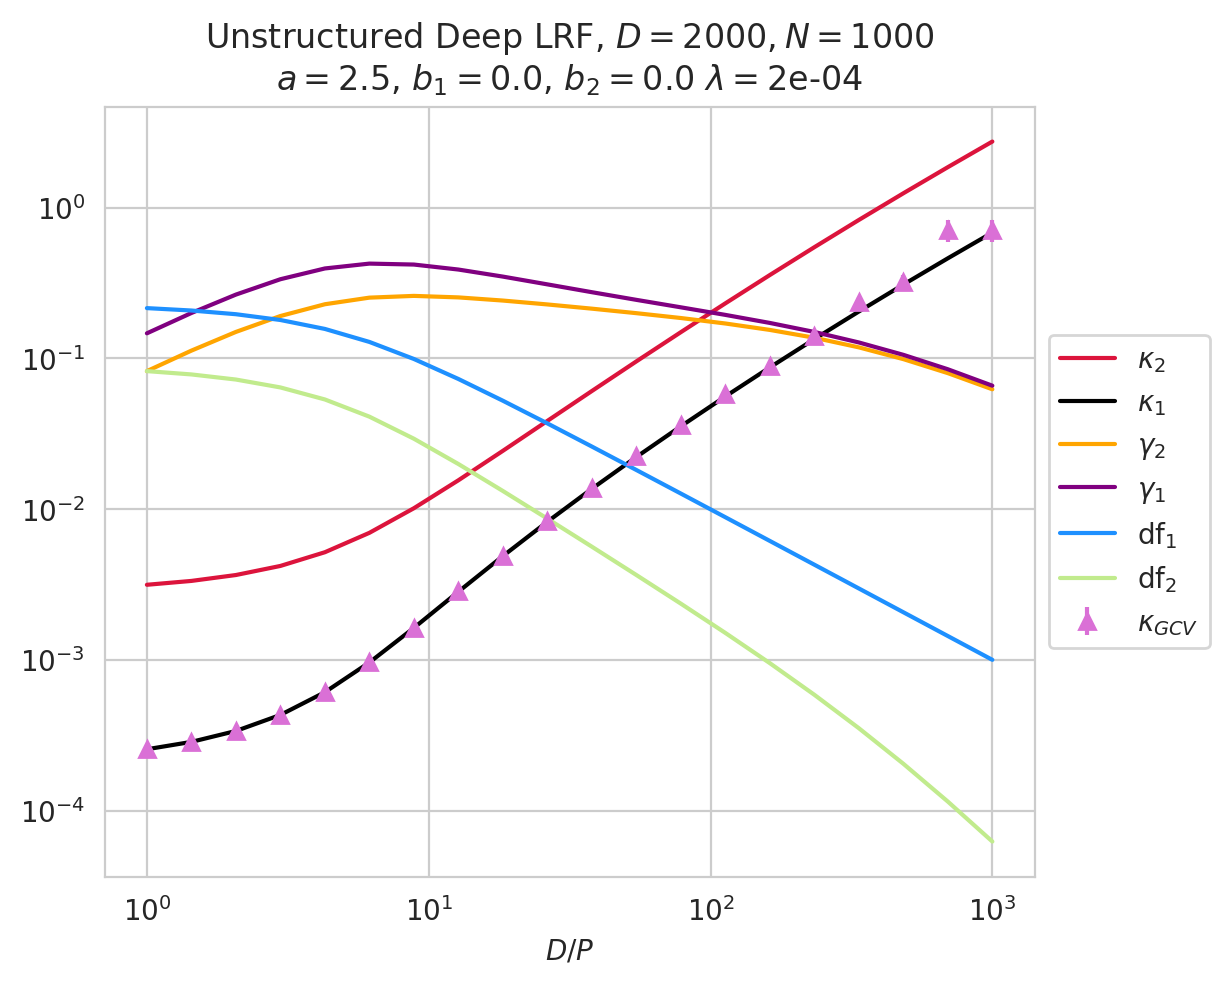

In [99]:
sns.set_palette('rainbow', n_colors=7)
plt.figure(figsize=(6, 5))
plt.plot(qs2, thry['kappa2'], label="$\\kappa_2$", c='crimson')
plt.plot(qs2, thry['kappa1'], label="$\\kappa_1$", c='k')
plt.plot(qs2, thry['gamma2'], label="$\\gamma_2$", c='orange')
plt.plot(qs2, thry['gamma1'], label="$\\gamma_1$", c='purple')
plt.plot(qs2, thry['df1k2'], label="df$_1$", c='dodgerblue')
plt.plot(qs2, thry['df2k2'], label="df$_2$", c='C4')
plt.errorbar(qs, expt['kappa_GCV'], expt['kappa_GCV_std'], label="$\\kappa_{GCV}$", c='orchid', marker='^', linestyle="")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$D/P$')
plt.title(f"Unstructured Deep LRF, $D={D}, N={N}$\n$a=${a}, $b_1=${b1}, $b_2=${b2} $\\lambda=${lamb:.0e}")

In [1]:
keys = ['Eg', 'Etr', 'Bias', 'VarX', 'VarF', 'VarXF', 'VarXe', 'VarXFe']
colors = ['k', 'b', 'forestgreen', 'orange', 'purple', 'pink', 'red', 'crimson']
labels = ["$E_g$", "$E_{tr}$", "Bias$^2$", "Var$_X$", "Var$_F$", "Var$_{{X, F}}$", "Var$_{{X, \\epsilon}}$", "Var$_{{X, F, \\epsilon}}$"]
for i in range(len(keys)):
    key, color, label = keys[i], colors[i], labels[i]
    if key+'_std' in expt:
        plt.errorbar(1/qs, expt[key], np.minimum(expt[key+'_std'], expt[key]*0.9),  c=color, marker='o', linestyle='', label=label)
    else:
        plt.plot(1/qs, expt[key], c=color, marker='o', linestyle='', label=label)
    plt.plot(1/qs2, thry[key], c=color)

E_GCV = (expt['kappa_GCV']/lamb)**2 * expt['Etr'] - sigma_epsilon**2
E_GCV_std = (expt['kappa_GCV']/lamb)**2 * expt['Etr_std']
E_GCV_std = np.where(E_GCV_std > E_GCV, E_GCV/2, E_GCV_std)
plt.errorbar(1/qs, E_GCV,  E_GCV_std, c='orchid', marker='^', linestyle='', label='GCV', zorder=3)

plt.plot([N/D, N/D], [0, 1e1], linestyle='--', color='grey', label="N/D")

plt.xlabel(r'$P/D$')
plt.ylabel('Error')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1e1)
plt.title(f"Structured Input Deep LRF, $a=${a}, $b_1=${b1}, $b_2=${b2}\n $\\lambda=${lamb:.0e}, $\\sigma_\\epsilon=${sigma_epsilon}")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

NameError: name 'expt' is not defined